# 画像処理検討ノート

In [800]:
from __future__ import unicode_literals
from __future__ import print_function
import sys
import os
import math
import random
import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import json
import scipy.ndimage
import PIL.Image

import chainer
import chainer.functions as F
import chainer.links as L

%matplotlib inline
sns.set_style('whitegrid')

In [120]:
sys.path.append(os.path.join(os.path.dirname(os.path.abspath('__file__')), '..', 'cmd', 'yolo', 'lib'))
from bounding_box import *

In [3]:
sys.version

'2.7.13 |Anaconda 4.3.0 (x86_64)| (default, Dec 20 2016, 23:05:08) \n[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]'

In [4]:
cv2.__version__

'3.1.0'

In [5]:
chainer.__version__

'1.22.0'

## ダミー背景の作成

In [427]:
bg_color_image_path = '/Users/uents/repos/github.com/uents/chainer-playground/dl-course/contest/APC/Single/Single/2/13/color.bmp'
bg_label_image_path = '/Users/uents/repos/github.com/uents/chainer-playground/dl-course/contest/APC/Single/mask_label/single/2/13/label.bmp'

In [428]:
bg_color_image = cv2.imread(bg_color_image_path)
bg_label_image = cv2.imread(bg_label_image_path, 0)

In [440]:
bg_label_image.shape[:2]

(960, 1280)

In [433]:
_, _, stats, centroids = cv2.connectedComponentsWithStats(bg_label_image)
stats, centroids

for stat, centroid in zip(stats, centroids):
    region_x, region_y, region_w, region_h, _ = stat[0], stat[1], stat[2], stat[3], stat[4]
    centor_x, centor_y = int(math.floor(centroid[1])), int(math.floor(centroid[0]))
    if region_w * region_h <= (2 * bg_label_image.shape[1]):
        continue
    if region_w * region_h >= (bg_label_image.shape[0] * bg_label_image.shape[1] * 0.95):
        continue
    break

region_x, region_y, region_w, region_h

(712, 676, 124, 188)

In [445]:
240 * 180

43200

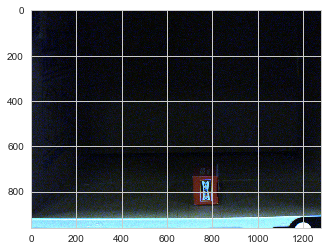

In [434]:
fig, axes = plt.subplots(1,1)
axes.imshow(cv2.cvtColor(bg_color_image, cv2.COLOR_BGR2RGB))

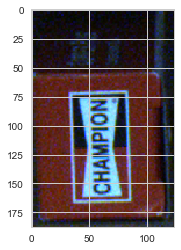

In [436]:
fig, axes = plt.subplots(1,1)
axes.imshow(cv2.cvtColor(bg_color_image[676:676+188,712:712+124], cv2.COLOR_BGR2RGB))

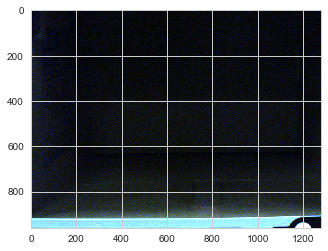

In [822]:
bg_image = color_image1.copy()
bg_image[676:676+188,712:712+124] = bg_color_image[676:676+188,712+124:712+124+124]
fig, axes = plt.subplots(1,1)
axes.imshow(cv2.cvtColor(bg_image, cv2.COLOR_BGR2RGB))

In [453]:
'bg_image%02d.bmp' % 2

u'bg_image02.bmp'

In [324]:
cv2.imwrite('bg.bmp', bg_image)

True

## オブジェクトの抽出

In [840]:
with open(os.path.join('..', 'cache', 'single_catalog.json'), 'r') as fp:
    catalog = json.load(fp)
    
train_dataset = filter(lambda item: item['bounding_boxes'] != [], catalog['dataset'])
len(train_dataset)

749

In [852]:
dataset = train_dataset[3]

In [853]:
color_image_path = dataset['color_image_path']
label_image_path = dataset['label_image_path']
bbox = dataset['bounding_boxes'][0]

bbox

{u'class': u'1',
 u'height': u'260',
 u'width': u'1246',
 u'x': u'0',
 u'y': u'696'}

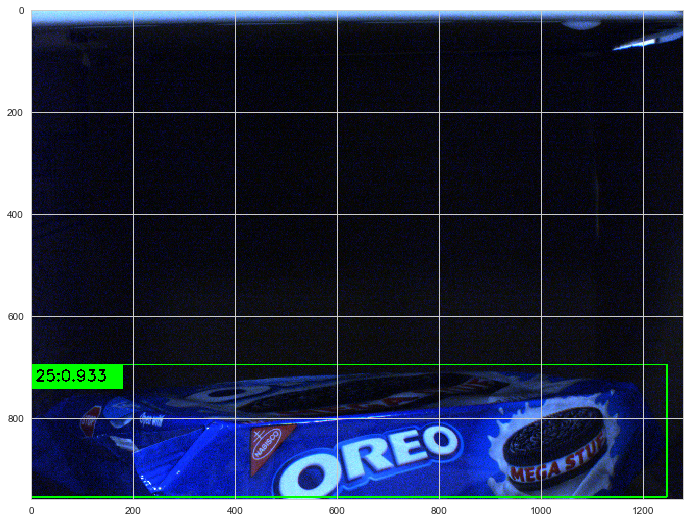

In [894]:
color_image = cv2.imread(color_image_path)

x = int(bbox['x'])
y = int(bbox['y'])
w = int(bbox['width'])
h = int(bbox['height'])

cv2.rectangle(color_image, (x, y), (x+w, y+h), [0,255,0], thickness=2)
cv2.rectangle(color_image, (x, y), (x+180, y+48), [0,255,0], thickness=-1)
cv2.putText(color_image, '25:0.933', (x+8, y+32), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), thickness=2)

fig, axes = plt.subplots(1,1, figsize=(12,9))
axes.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))

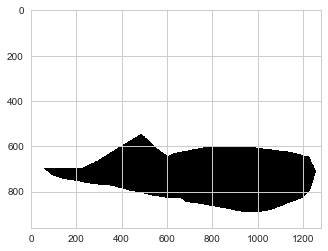

In [827]:
label_image = cv2.imread(label_image_path, 0)
fig, axes = plt.subplots(1,1)
axes.imshow(label_image)

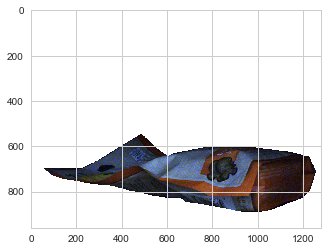

In [828]:
roi_image = cv2.bitwise_and(color_image, color_image, mask=label_image)
roi_image = cv2.cvtColor(roi_image, cv2.COLOR_BGR2BGRA)
roi_image[label_image == 0, 3] = 0

fig, axes = plt.subplots(1,1)
axes.imshow(cv2.cvtColor(roi_image, cv2.COLOR_BGRA2RGBA))

<Box x:58.0 y:545.0 w:1200.0 h:344.0 c:0>


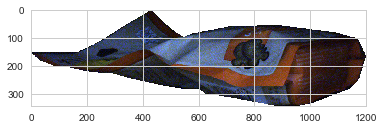

In [829]:
box = Box(
    x=int(bounding_box['x']),
    y=int(bounding_box['y']),
    w=int(bounding_box['width']),
    h=int(bounding_box['height'])
)
print(box)

obj_image = roi_image[box.top:box.bottom,box.left:box.right]
fig, axes = plt.subplots(1,1)
axes.imshow(cv2.cvtColor(obj_image, cv2.COLOR_BGRA2RGBA))

In [830]:
def rotate_image(image, angle):
    return scipy.ndimage.rotate(image, angle, reshape=True)

def scale_image(image, scale):
    h, w = image.shape[:2]
    return cv2.resize(image, (int(w*scale), int(h*scale)))

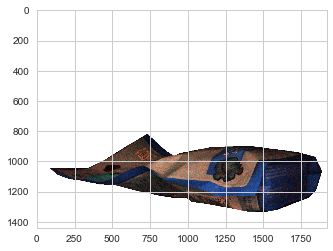

In [831]:
obj_image = scale_image(roi_image, 1.5)
fig, axes = plt.subplots(1,1)
axes.imshow(obj_image)

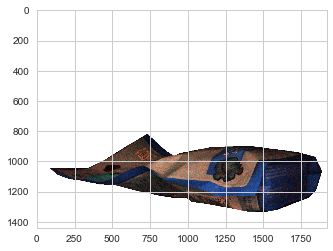

In [832]:
new_image = rotate_image(obj_image, 0)
fig, axes = plt.subplots(1,1)
axes.imshow(new_image)

In [833]:
print(obj_image.shape)

(1440, 1920, 4)


## オブジェクトをダミー背景に重畳

-280 -528 1920 1440 1280 960


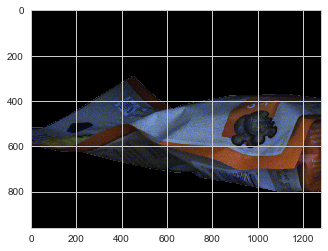

In [834]:
new_pimage = PIL.Image.fromarray(cv2.cvtColor(black_image, cv2.COLOR_BGR2RGBA))
obj_pimage = PIL.Image.fromarray(cv2.cvtColor(obj_image, cv2.COLOR_BGRA2RGBA))

oh, ow = obj_image.shape[:2]
bh, bw = bg_image.shape[:2]
ox = int((bw-ow)/2 + random.uniform(-0.4*(bw-ow), 0.4*(bw-ow)))
oy = int((bh-oh)   - max(random.uniform(0.1*(bh-oh), 0.3*(bh-oh)), 0.05*bh))
print(ox, oy, ow, oh, bw, bh)

new_pimage.paste(obj_pimage, box=(ox, oy), mask=obj_pimage)

fig, axes = plt.subplots(1,1)
axes.imshow(new_pimage)

In [835]:
new_image = cv2.cvtColor(np.asarray(new_pimage), cv2.COLOR_RGBA2BGR)

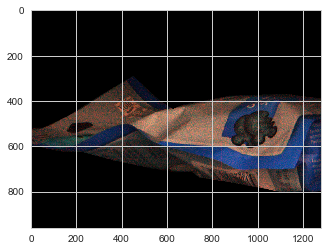

In [836]:
new_image2 = cv2.rectangle(new_image, (ox, oy), (ow, oh), [0,255,0], thickness=2)

fig, axes = plt.subplots(1, 1)
axes.imshow(new_image2)

In [495]:
random.uniform(-36, 36)

13.351338285652936

In [613]:
random.randint(0,360)

137

In [649]:
def load_class_color_table():
    path = os.path.join(os.path.dirname(os.path.abspath('__file__')),
                        '..', 'lib', 'item_table.csv')
    with open(path, 'r') as fp:
        df = pd.read_csv(fp, encoding='cp932', index_col=['class'])
    return df

In [650]:
df_class_color_table = load_class_color_table()
df_class_color_table

,r,g,b
class,,,
0,0,0,0
1,128,0,0
2,255,0,0
3,0,128,0
4,128,128,0
5,255,128,0
6,0,255,0
7,128,255,0
8,255,255,0


In [661]:
def find_class_by_color(df, r=0, g=0, b=0):
    indexer = (df['r'] == r) & (df['g'] == g) & (df['b'] == b)
    return int(df_class_color_table[indexer].index[0])

In [662]:
find_class_by_color(df_class_color_table, 128, 128, 255)

22

In [665]:
df_class_color_table.ix[22,'r']

128

In [673]:
def find_color_by_class(df, clazz=0):
    return int(df.ix[clazz,'r']), int(df.ix[clazz,'g']), int(df.ix[clazz,'b'])

In [675]:
find_color_by_class(df_class_color_table, 22)

(128, 128, 255)

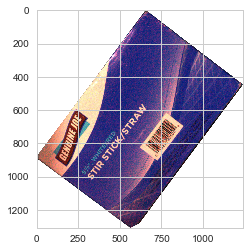

In [655]:
plt.imshow(obj_image)

In [657]:
obj_image[:,:,3] != 0

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

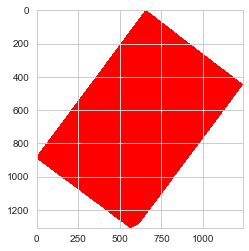

In [676]:
label_image = obj_image.copy()
label_image[obj_image[:,:,3] > 0] = [255,0,0,255]
plt.imshow(label_image)

In [670]:
bg_image.shape

(960, 1280, 3)

In [693]:
black_image = np.tile(0, bg_image.shape).astype(np.uint8)

In [684]:
overlay_image(label_image, black_image)

TypeError: 'Image' object is not callable

In [695]:
'2'.zfill(2)

u'02'

In [696]:
os.path.exists('..')

True

In [697]:
cv2.INTER_L

In [700]:
cv2.resize(bg_image, (640, 480))

array([[[ 23,   8,   9],
        [ 20,   5,   7],
        [  1,   4,   8],
        ..., 
        [  1,   2,  13],
        [  8,   3,   8],
        [  1,   4,   8]],

       [[  2,   8,  10],
        [ 48,   6,   7],
        [ 38,   8,   6],
        ..., 
        [  0,   2,  13],
        [  0,   8,   7],
        [  9,   3,  10]],

       [[  7,   5,  13],
        [  4,   6,   9],
        [ 26,  13,   7],
        ..., 
        [ 27,   4,   6],
        [  1,  10,   8],
        [  0,   6,   8]],

       ..., 
       [[232, 240, 158],
        [249, 227, 146],
        [255, 212, 145],
        ..., 
        [ 54,   7,   5],
        [ 22,  11,   7],
        [ 33,  15,   5]],

       [[254, 221, 150],
        [251, 221, 143],
        [254, 220, 140],
        ..., 
        [ 17,  11,  11],
        [ 23,  14,   6],
        [ 48,  12,   4]],

       [[253, 195, 134],
        [253, 195, 127],
        [225, 195, 124],
        ..., 
        [ 35,  16,   5],
        [  1,   7,   7],
        [ 12,  10,

In [701]:
class Box():
    def __init__(self, x, y, w, h, clazz=0):
        self.left = x
        self.top = y
        self.width = w
        self.height = h
        self.clazz = clazz

    def __repr__(self):
        return '<Box x:%4.1f y:%4.1f w:%4.1f h:%4.1f c:%d>' % \
            (self.left, self.top, self.width, self.height, self.clazz)

    @property
    def right(self):
        return self.left + self.width

    @property
    def bottom(self):
        return self.top + self.height

    @property
    def area(self):
        return self.width * self.height

    @property
    def aspect(self):
        return float(self.width) / (self.height)

In [703]:
box = Box(2,4,6,8)
box

<Box x: 2.0 y: 4.0 w: 6.0 h: 8.0 c:0>

In [705]:
min(-1, 0, 2, 4)

-1

In [758]:
np.random.choice(np.arange(0,100), size=2)

array([ 0, 60])

In [760]:
np.arange(0,100)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [765]:
np.random.choice(train_dataset, size=2)

2

In [761]:
np.asarray(zip(a,b))

array([[ 1, 11],
       [ 2, 12],
       [ 3, 13],
       [ 4, 14],
       [ 5, 15]])

In [767]:
100 % 100 == 0

True

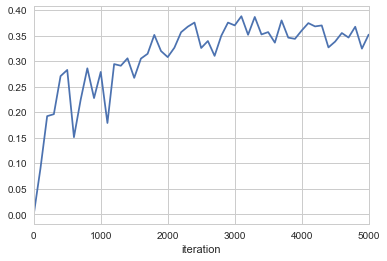

In [788]:
with open('/Users/uents/train_log.csv', 'r') as fp:
    df = pd.read_csv(fp, index_col=['iteration'])

df['cv_map'].plot()

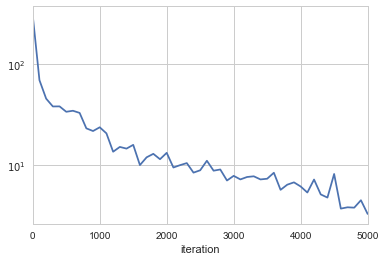

In [785]:
df['train_loss'].plot(logy=True)

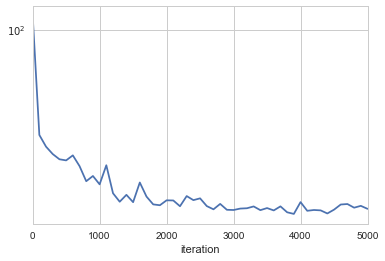

In [786]:
df['cv_loss'].plot(logy=True)

In [780]:
se = df['cv_loss']
se.plot?

In [796]:
(12 * 1024 / (4. / 8)) / 60 / 60

6.826666666666667

In [804]:
dt.datetime.now().strftime('%Y-%m-%d_%H%M%S')

'2017-04-12_201904'